In [2]:
'''Prepare the notebook. Run this cell first.'''
import os, re, sys
import pandas as pd
import numpy as np
from IPython.display import Image

%load_ext rpy2.ipython

In [68]:
'''Set parameters.  Run this cell before all others.'''
study_name = 'merged_neighbor' #Change this to match your PLINK binary filestem (*.bed, *.bim, *.bam).
thousand_genomes_filestem = '/clink/1kGP/1kGP_no_ATCG_LD_pruned' #This dataset contains 36.5M LD-pruned 1kGP variants.
min_maf = 0.01 #Remove variants below this frequency. Set to 0 to keep all variants.
max_missing_sample_callrate = 0.03 #Remove samples that have greater than this percent of missing genotypes ("sample callrate").
max_missing_marker_callrate = 0.03 #Remove SNPs that have greater than this percent of missing calls ("marker callrate").
max_IBD = 0.125 #Remove samples that have identity by state greater than this coefficient of relationship (first cousins).
min_HWE_p = 0.00001 #Remove SNPs with HWE exact test p-values lower than this.
min_diffmiss_p = 0.00001 #Remove SNPs with differential missingness test p-values lower than this.

In [3]:
'''Get the current instance's number of CPU cores and RAM.'''
ncpu_string = !nproc #Linux command to return the number of CPUs.
ncpu = int(ncpu_string[0]) #Convert to Python integer.
ram_string = !cat /proc/meminfo | fgrep MemTotal | perl -lane 'use POSIX; print floor($F[1] / 1024) #Convert from kB to MB'
ram = int(ram_string[0])

In [4]:
'''Make analysis directory and upload your data'''

import os
study_dir = '/clink/' + study_name #Can change this variable to suit your study. 
#The base directory, /clink/, is the mountpoint for the encrypted EBS device.
if not os.path.isdir(study_dir): os.mkdir(study_dir)
%cd {study_dir}

#You can either upload data to the EC2 instance using the key pair you specified at instance launch,
#  for instance using scp from a system that has your data,
#  or you can fetch the data from this instance using SFTP/rsync/curl/wget/s3

#Remember that if you want to pull data from a private S3 bucket, the EC2 instance needs to assume an IAM role,
#  and that bucket must be configured for the EC2 instance's IAM role.

#In this example, I used scp from a firewalled and secured workstation to securely upload a Plink study to the EC2 instance.
#I used a command like this from my workstation:
#scp -i my_key_pair.pem my_study.* ec2-user@<IPv4_public_IP>:/gwas/my_study/
#  ..where <IPv4_public_IP> is the public IPv4 address of the EC2 instance running this notebook.

input_filestem  = study_name #This variable will be used throughout QC.

/clink/merged_neighbor


In [5]:
'''Instantiate results object to hold QC results at each step.'''
class Results():
    '''Class to hold results of each QC step.'''
    def __init__(self):
        self.results = pd.DataFrame(columns=['step_number', 'step_name', 'n_snps', 'n_samples']) #Declare empty DataFrame to update.
    def add_result(self, result):
        self.results = self.results.append(result, ignore_index=True)
    def get_results(self):
        return self.results
    
class Result():
    '''Class to hold results of a single QC step.'''
    def __init__(self, step_number, step_name, n_snps_and_samples):
        self.result = pd.Series({'step_number': step_number,
                                 'step_name': step_name,
                                 'n_snps': n_snps_and_samples[0],
                                 'n_samples': n_snps_and_samples[1]})
        self.result.reindex(index=['step_number', 'step_name', 'n_snps', 'n_samples'])
    def get_result(self):
        return self.result #Simple accessor.
    
def count_snps_and_samples(filestem):
    '''Given a string representing a binary Plink filestem, count the samples and SNPs.'''
    snp_count, sample_count = 0, 0
    bim_file_name, fam_file_name = filestem + '.bim', filestem + '.fam'
    with open(bim_file_name) as bim, open(fam_file_name) as fam:
        for line in bim: snp_count += 1
        for line in fam: sample_count += 1
    return snp_count, sample_count #Tuple.
    
results = Results() #Instantiate results object to keep track of QC results at each step.
results.add_result(Result(0, 'Initial dataset', count_snps_and_samples(input_filestem)).get_result())

In [6]:
'''1) Run sex check using plink.'''

#This should generate a *.sexcheck file for the study:
!plink --bfile $input_filestem --check-sex --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --check-sex
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%

In [7]:
sexcheck_file = input_filestem + '.sexcheck'
sexprobs_file = input_filestem + '.sexprobs'

!fgrep PROBLEM $sexcheck_file > $sexprobs_file
sexproblems = !cat $sexprobs_file | wc -l
print("Number of gender discordances detected: " + str(sexproblems))

#Save the FID and IID of the individuals that failed qc, if any.
#It's okay to generate an empty file here - we'll count the lines of each fail-* file later for a sumamry.
!perl -lne 's/^\s+//; @f = split; print join "\t", (@f[0..1])' $sexprobs_file >fail-sexcheck-qc.txt

#At this point, inspect the reasons for any gender discordances.  In this case, some genders are missing in the ped file:
!head -1 $sexcheck_file #For the header.
!head -5 $sexprobs_file #Check out the first 5 discordances.

Number of gender discordances detected: ['151']
         FID          IID       PEDSEX       SNPSEX       STATUS            F
      ME8001       ME8001            0            2      PROBLEM     -0.03585
      ME8002       ME8002            0            1      PROBLEM            1
      ME8003       ME8003            0            1      PROBLEM            1
      ME8004       ME8004            0            2      PROBLEM    -0.004742
      ME8005       ME8005            0            2      PROBLEM     -0.04665


In [8]:
'''Exclude samples that failed sexcheck QC.'''
!plink --bfile $input_filestem --remove fail-sexcheck-qc.txt --make-bed --out $input_filestem


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --out merged_neighbor
  --remove fail-sexcheck-qc.txt

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
655216 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
--remove: 5032 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%

In [9]:
'''Update running Results() object.'''
results.add_result(Result(1, 'Sexcheck', count_snps_and_samples(input_filestem)).get_result())
results.get_results() #See the running result.

,step_number,step_name,n_snps,n_samples
0,1.0,Sexcheck,655216.0,5032.0


In [10]:
'''2) Marker callrate.'''
!plink --bfile $input_filestem --geno $max_missing_marker_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.03
  --make-bed
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
655216 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48

In [11]:
'''Update running Results() object.'''
results.add_result(Result(2, 'Marker callrate', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [12]:
'''3) Sample callrate.'''
!plink --bfile $input_filestem --mind $max_missing_sample_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --mind 0.03
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
555021 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%

In [13]:
'''Update running Results() object.'''
results.add_result(Result(3, 'Sample callrate', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [14]:
'''4) MAF'''
!plink --bfile $input_filestem --maf $min_maf --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --maf 0.01
  --make-bed
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
555021 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%

In [15]:
'''Update running Results() object.'''
results.add_result(Result(4, 'MAF', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [32]:
'''5) IBD'''
'''Generate a missingness report and LD-pruned variants first.'''
!plink --bfile $input_filestem --missing --out $input_filestem
!plink --bfile $input_filestem --indep-pairwise 50 5 0.2 --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --missing
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
535483 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%6

In [33]:
'''If the above output pruned too few or too many SNPs, adjust the linkage R^2 value 
Increase R^2 to retain more SNPs, decrease to prune more.
The goal is to end up with about 100k SNPs for a GWAS study (>= 500k SNPs genome-wide).
Then proceed with identification of related samples.'''
prune_in_file = input_filestem + '.prune.in'
unlinked_variant_count = !cat $prune_in_file | wc -l
print "Unlinked (LD-pruned) genetic variant count: " + str(unlinked_variant_count)
!plink --bfile $input_filestem --extract $prune_in_file --genome --out $input_filestem
#That command should generate a *.genome file.  This might be the most computationally heavy cell in the notebook.
#IBD calculation "used to take weeks" according to a collaborator.  Plink's IBD computation is now fast.

Unlinked (LD-pruned) genetic variant count: ['113323']
PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --extract merged_neighbor.prune.in
  --genome
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
535483 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
--extract: 113323 variants remaining.
Using up to 4 threads (change this with --threads).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44

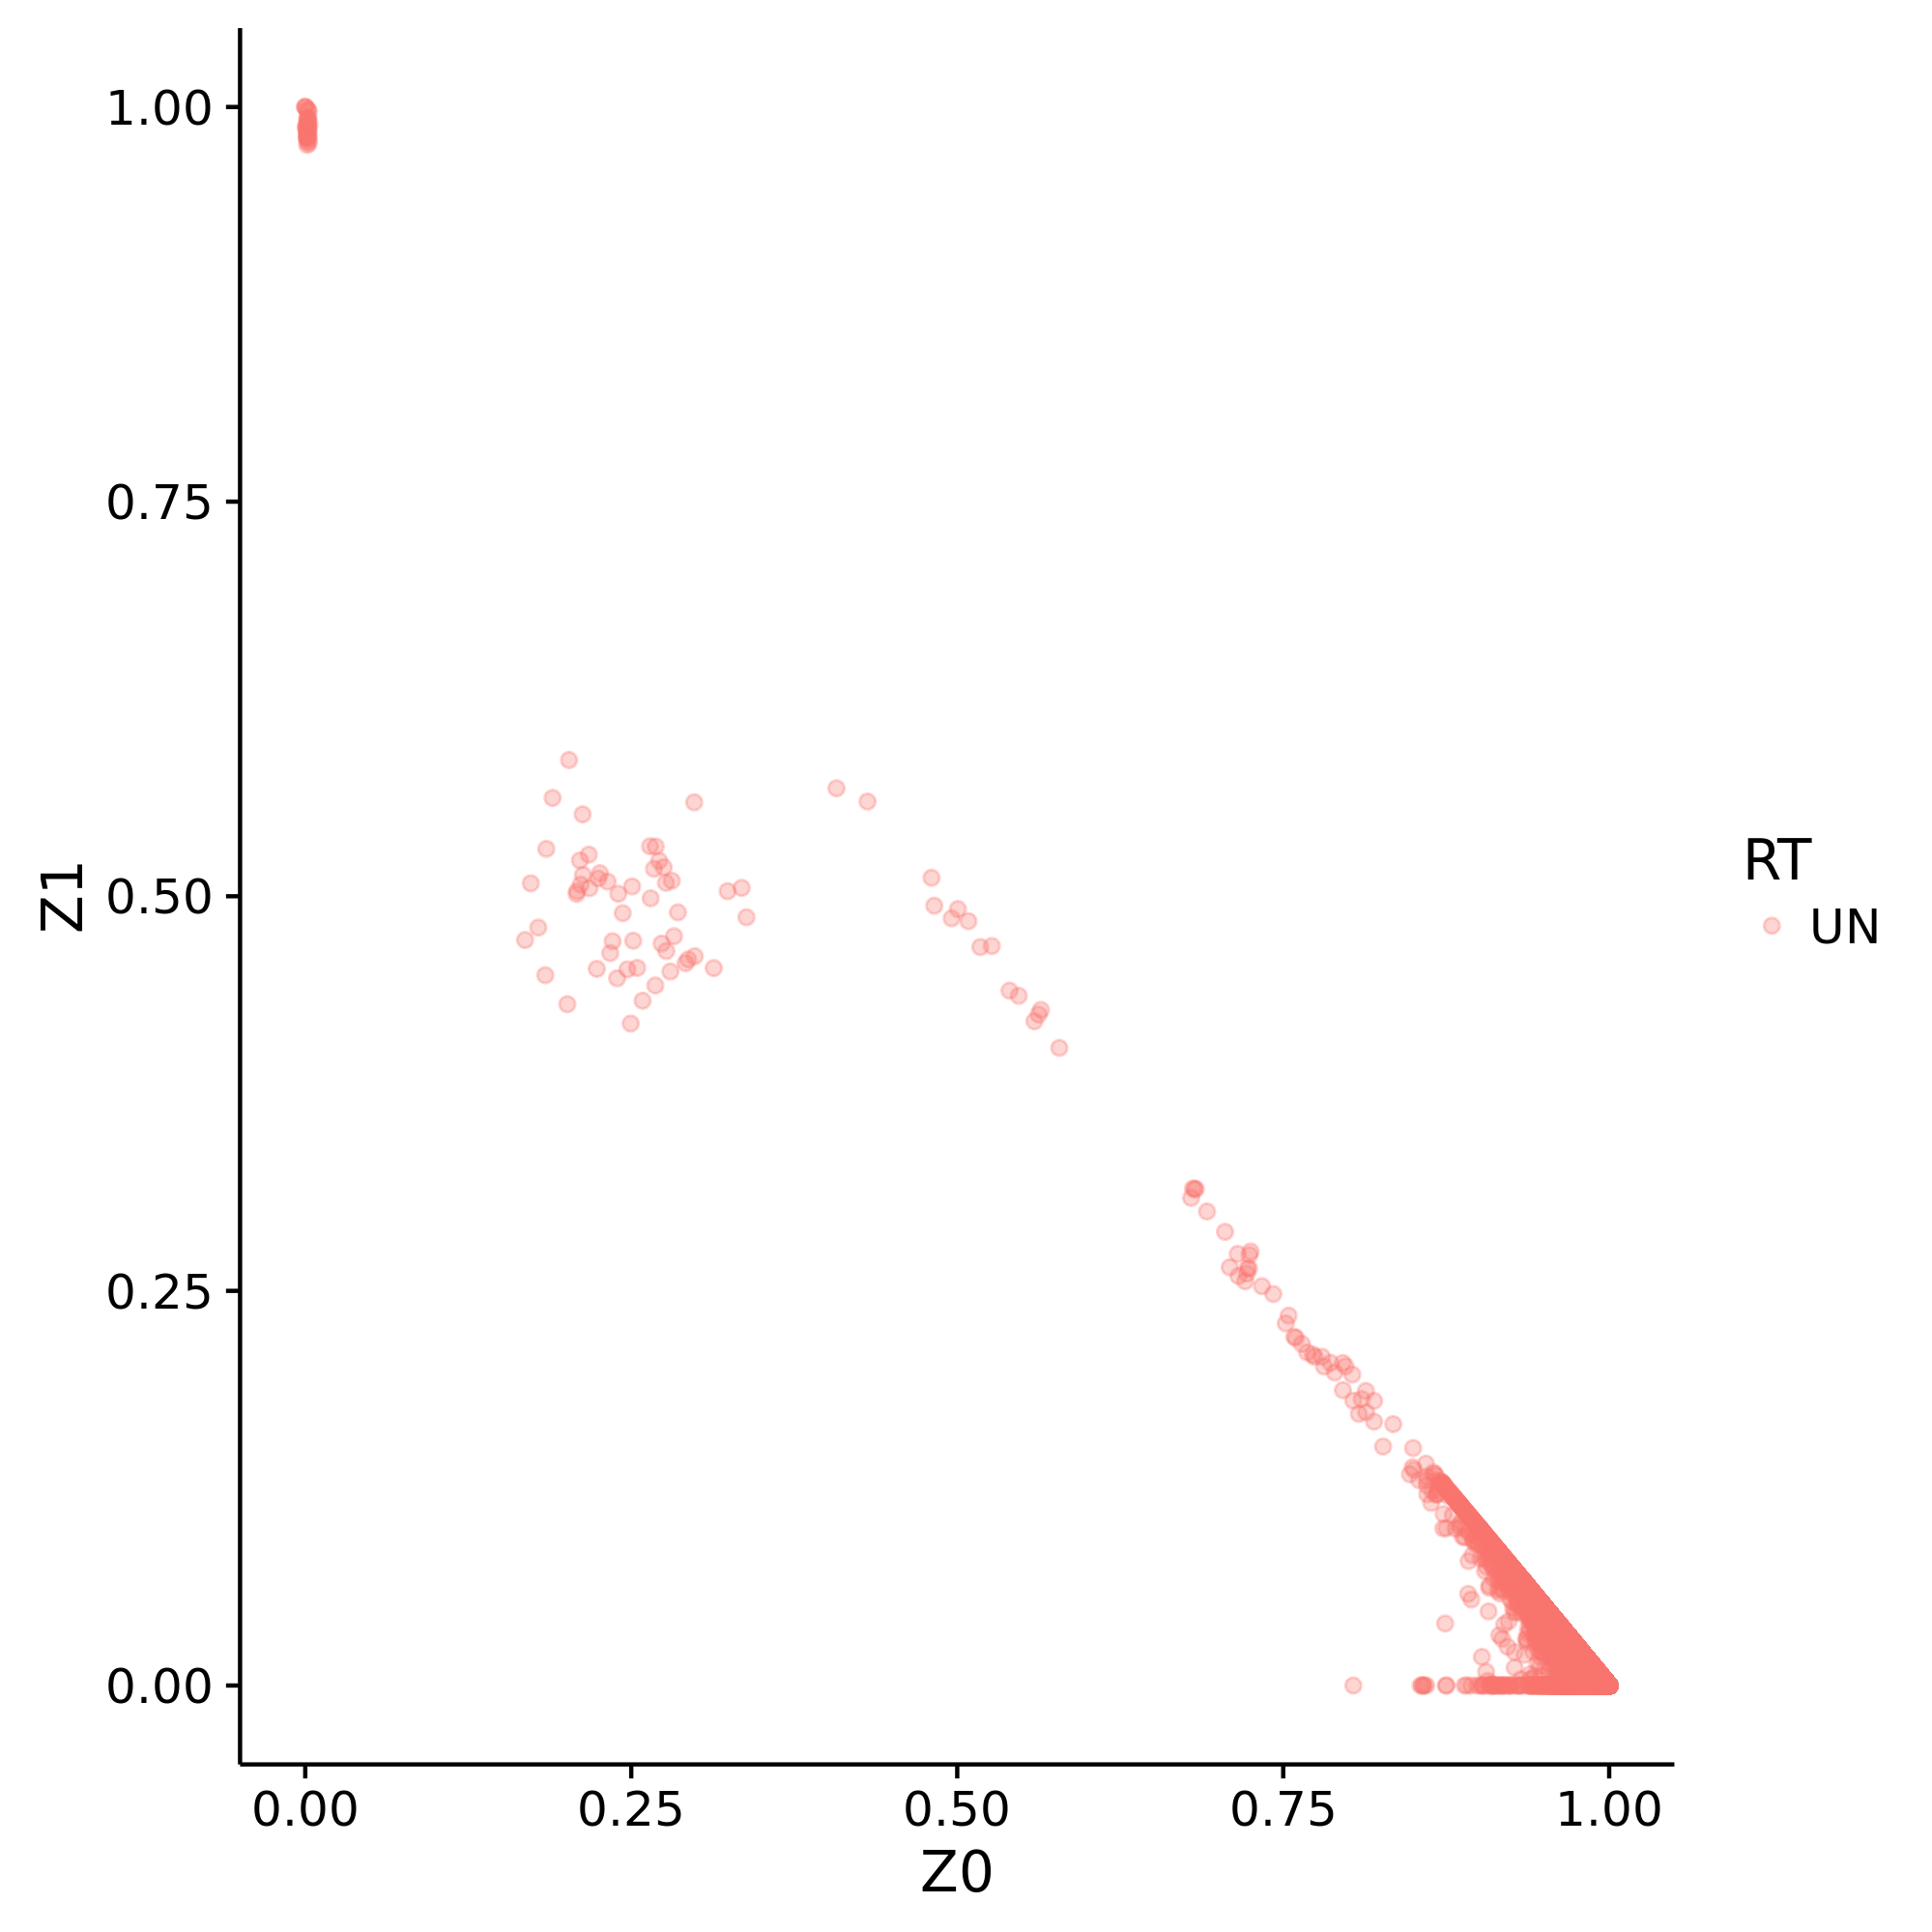

In [35]:
genome_file = input_filestem + '.genome'
imiss_file = input_filestem + '.imiss'
#Clean up the whitespace:
!perl -i -lpe 's/^\s+//; s/\s+/\t/g;' $genome_file $imiss_file

#Now plot the relationships. This will take a while for a huge study!
%Rpush genome_file
%R genome <- read.table(genome_file, header=T)
%R library(ggplot2)
%R library(cowplot)
%R ggplot(genome, aes(x=Z0, y=Z1, colour=RT)) + geom_point(alpha=0.3)
%R ggsave('IBD_plot.pdf') #Save vectorized plot for presentation.
%R ggsave('IBD_plot.png') #For notebook display.
Image('IBD_plot.png')
#Inspect this plot for regions of known relationship types.  For a GWAS of presumably unrelated individuals,
#  most points should appear in the bottom right (Z0 near 1, Z1 near 0).

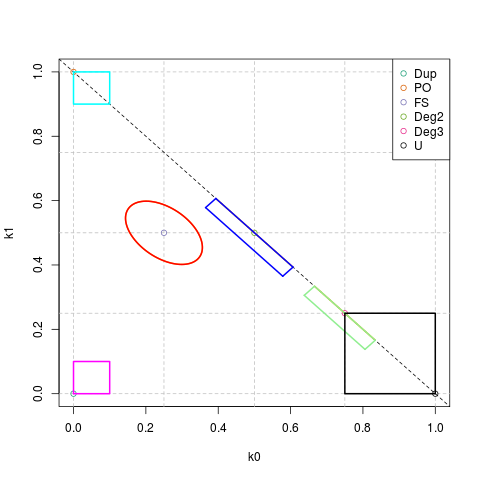

In [23]:
'''These are the expected values for known types of relationships, to help you interpret this plot above:
Z0    Z1    Z2    Kinship    Relationship
0     0     1     1          Duplicated sample, monozygotic twin, or clone (future)
0     1.0   0     0.5        Parent-offspring
0.25  0.5   0.25  0.5        Full siblings
0.5   0.5   0     0.25       Half siblings
0.75  0.25  0     0.125      Cousins
1.0   0     0     0          Unrelated
'''
#This image from the R Graphical Manual (http://www.imsbio.co.jp/RGM/R_rdfile?f=GWASTools/man/ibdPlot.Rd&d=R_BC)
#  might also be helpful.
Image('http://www.imsbio.co.jp/RGM-files/R_BC/result/GWASTools/ibdPlot.Rd_001_medium.png')

In [36]:
'''Generate a file containing FID:IID pairs of individuals to be excluded on the basis of relatedness.
Exclude the individual with greater missingness from any pair of individuals that are related more than first cousins.'''

imiss, removed = dict(), set()

with open(imiss_file) as imiss_in, open(genome_file) as genome_in, open('fail-IBD-QC.txt', 'w') as fail_IBD_out:
    #Read the missingness into a dictionary.
    header = imiss_in.readline()
    for line in imiss_in:
        fid, iid, miss_pheno, n_miss, n_geno, f_miss = line.rstrip().split("\t") #File was already whitespace-cleaned.
        imiss[(fid, iid)] = float(f_miss) #Key by FID:IID tuple, value by F_MISS (missing frequency).
        
    #Now exclude related samples. Drop whichever one has higher missingness.
    header = genome_in.readline()
    for line in genome_in:
        fid1, iid1, fid2, iid2, rt, ez, z0, z1, z2, pi_hat, phe, dst, ppc, ratio = line.rstrip().split("\t")
        if float(pi_hat) > 0.185:
            if imiss[(fid1, iid1)] >= imiss[(fid2, iid2)]: #The first sample has higher missingness.
                if (fid1, iid1) not in removed:
                    fail_IBD_out.write("\t".join([fid1, iid1]) + "\n")
                    removed.add((fid1, iid1)) #Remember that we already excluded this FID:IID pair.
            else: #The second sample has higher missingness.
                if (fid2, iid2) not in removed:
                    fail_IBD_out.write("\t".join([fid2, iid2]) + "\n")
                    removed.add((fid2, iid2))

fail_IBD_count = !cat fail-IBD-QC.txt | wc -l
print "Number of samples that failed IBD QC: " + str(fail_IBD_count)

Number of samples that failed IBD QC: ['83']


In [37]:
'''Now exclude the related samples from the study.'''
!plink --bfile $input_filestem --remove fail-IBD-QC.txt --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --out merged_neighbor
  --remove fail-IBD-QC.txt

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
535483 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
--remove: 4949 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%

In [38]:
'''Update running Results() object.'''
results.add_result(Result(5, 'IBD', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [39]:
'''6) Outlying heterozygosity.
First, visualize missingness and heterozygosity from reports.'''

!plink --bfile $input_filestem --missing --het --out $input_filestem
imiss_file = input_filestem + '.imiss'
het_file   = input_filestem + '.het'

#!head {imiss_file} #See how Plink generates some extra whitespace...
!perl -i -lpe 's/^\s+//; s/\s+/\t/g;' {imiss_file} {het_file} 
#!head {imiss_file} #Uncomment to see how this Perl one-liner cleaned up these two files for easy reading.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --het
  --missing
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
535483 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%

Summary of log10(missingness): [-4.367 -3.951 -3.657 -3.523 -3.186 -1.536]
Summary of mean heterozygosity: [ 0.243   0.3303  0.3318  0.3316  0.3333  0.3683]


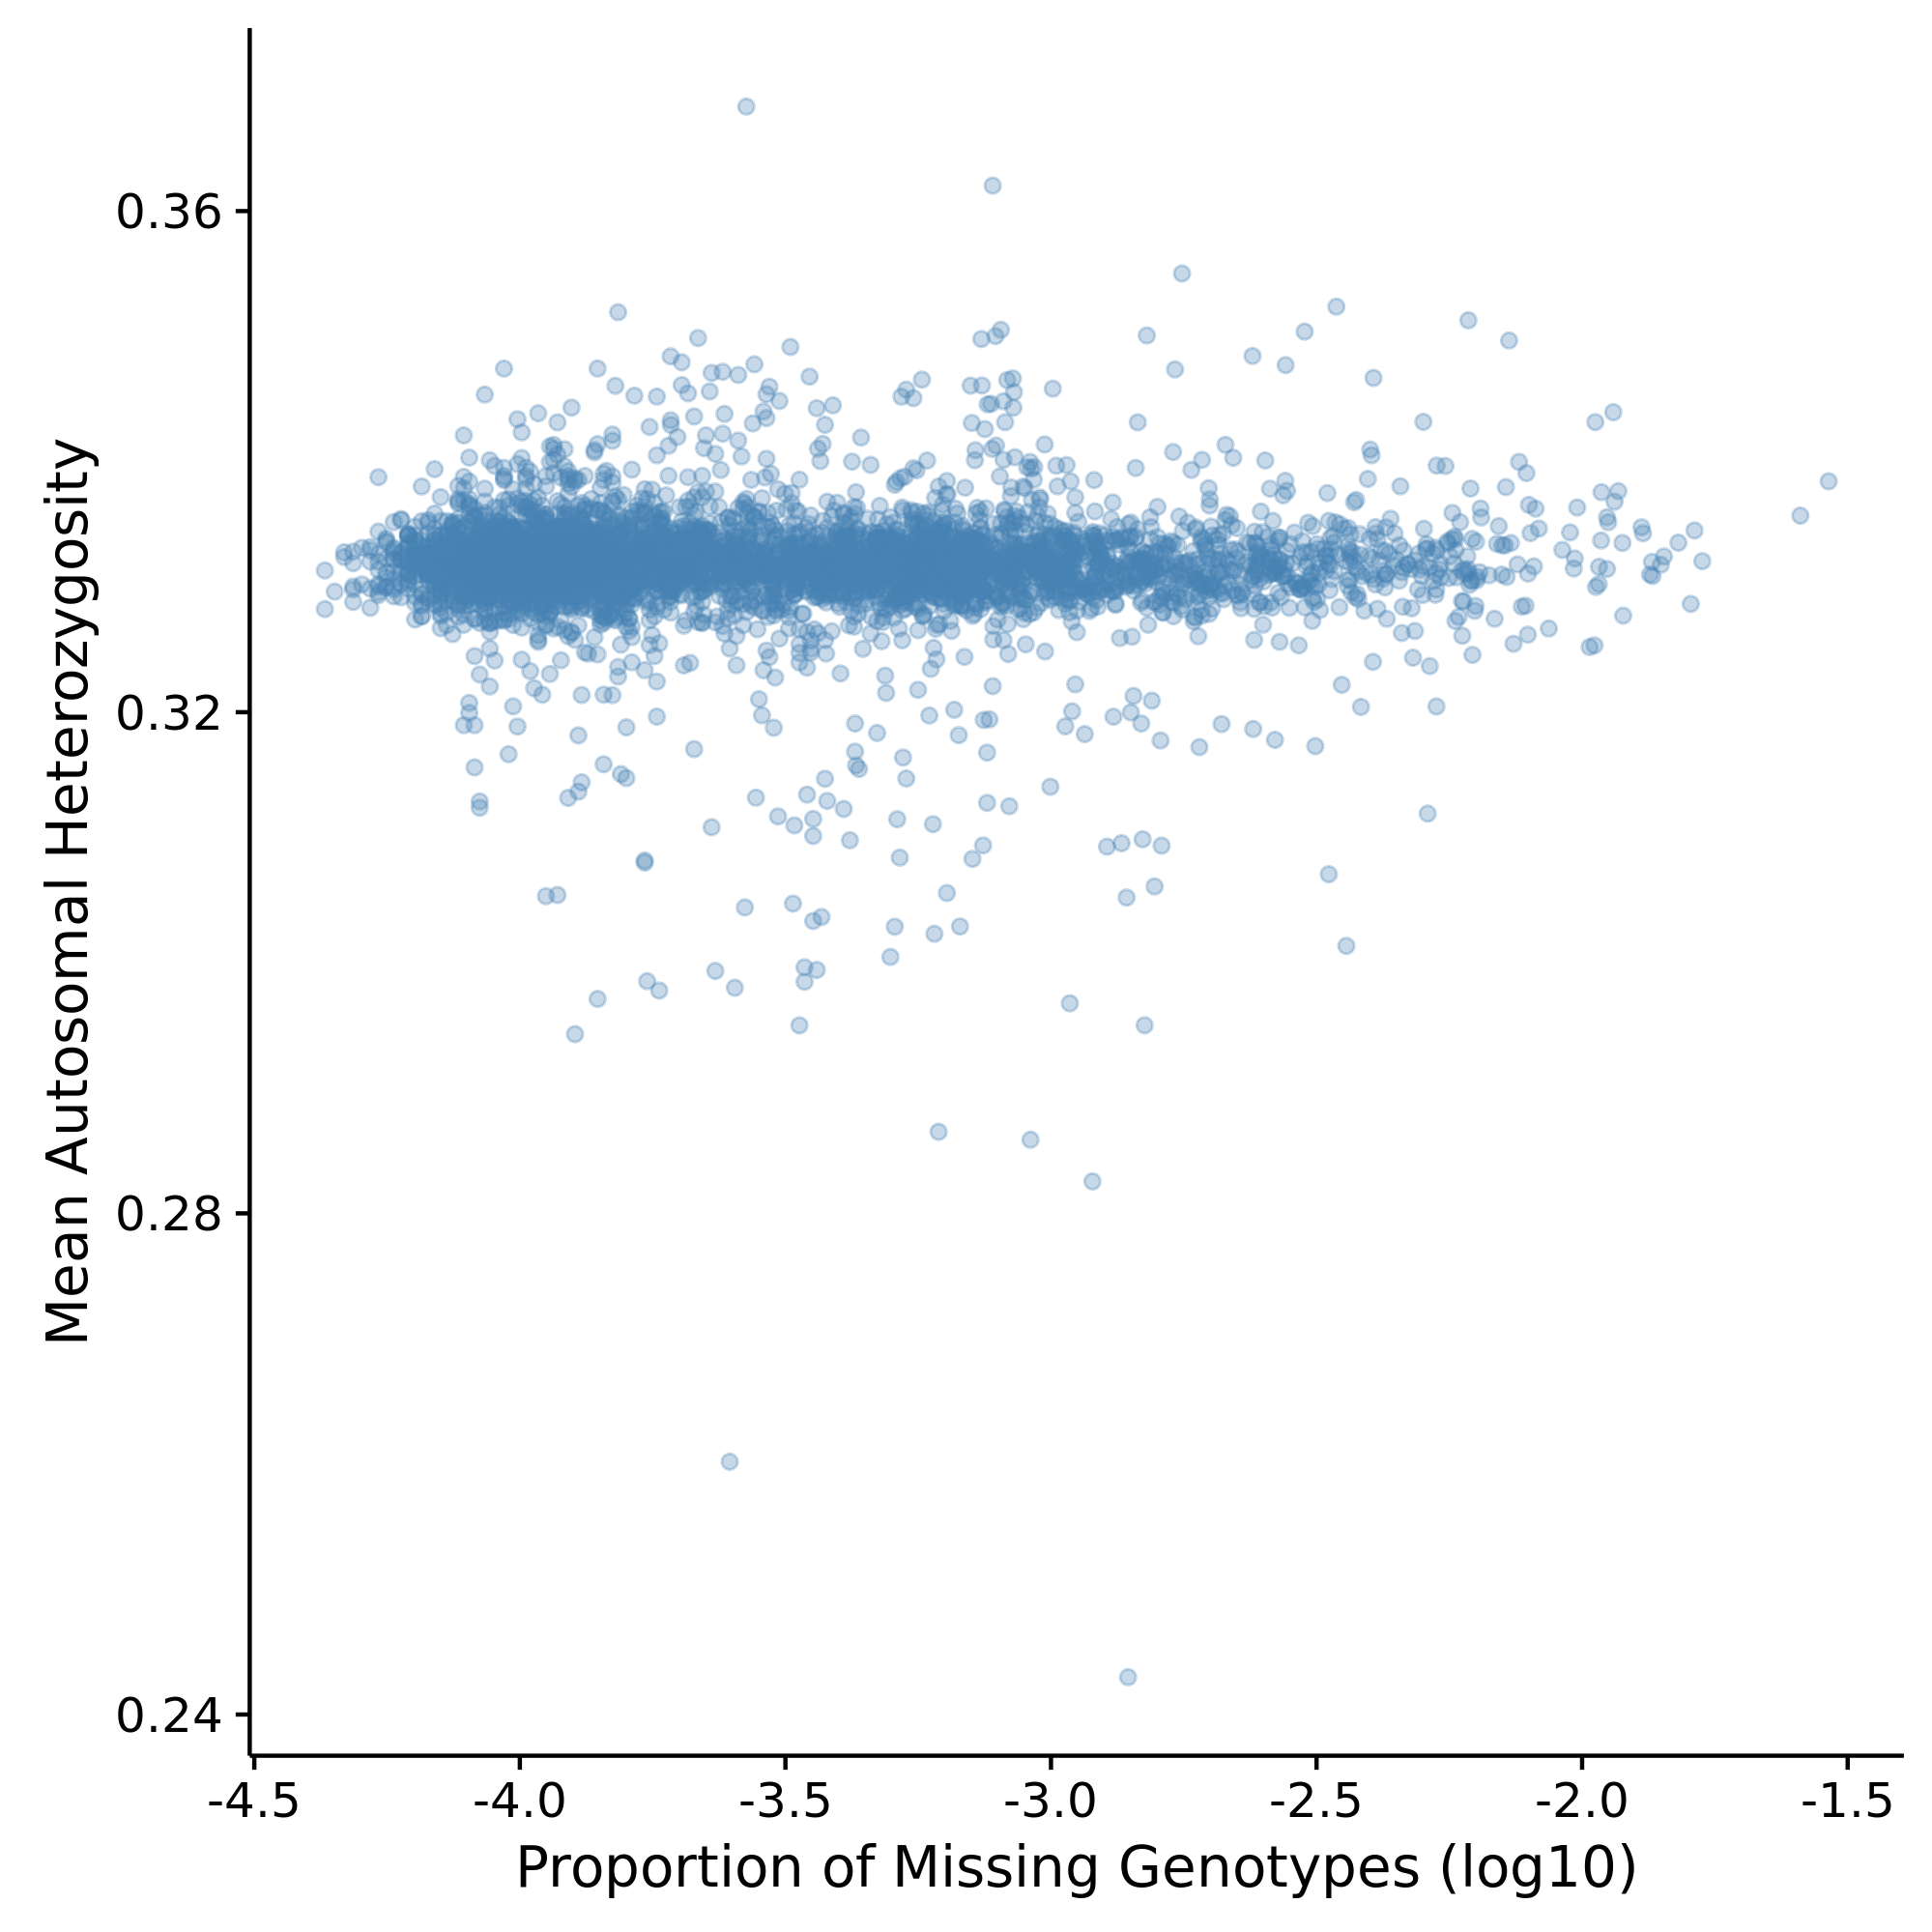

In [40]:
'''Plot missingness versus heterozygosity. Use Rmagic.'''

%Rpush imiss_file het_file
%R imiss <- read.table(imiss_file, header=T)
%R het   <- read.table(het_file,   header=T)
%R library(ggplot2)
%R library(cowplot)

#Calculate the log10 of the F_MISS and the mean heterozygosity (among non-missing genotypes).
%R imiss$logF_MISS <- log10(imiss$F_MISS)
%R het$meanHet     <-  (het$N.NM. - het$O.HOM.)/het$N.NM.

%R -o summary_logF_MISS summary_logF_MISS <- summary(imiss$logF_MISS)
print("Summary of log10(missingness): " + str(summary_logF_MISS))

%R -o summary_meanHet summary_meanHet <- summary(het$meanHet)
print("Summary of mean heterozygosity: " + str(summary_meanHet))

%R imiss_and_het <- merge(imiss, het, by='IID')


%R imiss_vs_het_scatterplot <- ggplot(imiss_and_het, aes(x=logF_MISS, y=meanHet)) + geom_point(alpha=0.3, colour='steelblue') + xlab("Proportion of Missing Genotypes (log10)") + ylab("Mean Autosomal Heterozygosity")
%R ggsave('imiss_vs_het.pdf') #Save publication-quality PDF.
%R ggsave('imiss_vs_het.png') #Save PNG for display in the notebook.
Image('imiss_vs_het.png')
#Inspect this plot for the distribution of missingness (x-axis) versus mean heterozygosity (y-axis).
#One can exclude samples with outlying heterozygosity, e.g. more than 3 standard deviations below the mean.

#Here's something similar in pure R:
#%R plot(imiss$logF_MISS, het$meanHet, pch=1, xlab="Proportion of missing genotypes", ylab="Heterozygosity rate",axes=F); axis(2,at=c(0,0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5),tick=T); axis(1,at=c(-3,-2,-1,0),labels=c(0.001,0.01,0.1,1)); abline(h=mean(het$meanHet) - (2 * sd(het$meanHet)), col="RED",  lty=2); abline(h=mean(het$meanHet) - (3 * sd(het$meanHet)), col="gray", lty=2); abline(h=mean(het$meanHet) + (2 * sd(het$meanHet)), col="red",  lty=2); abline(h=mean(het$meanHet) + (3 * sd(het$meanHet)), col="gray",  lty=2); abline(v=-1.522879, col="red", lty=2)


In [49]:
'''Write file containing FID:IID pairs for individuals with outlying heterozygosity'''
%R het.filt <- het[which( het$meanHet > (mean(het$meanHet) + 3 * sd(het$meanHet)) | het$meanHet < (mean(het$meanHet) - 3 * sd(het$meanHet)) ),]
%R write.table(het.filt[,c(1,2)], file="fail-het-qc.txt", sep="\t", row.names=F, col.names=F, quote=F)

In [50]:
fail_het_qc_count = !cat fail-het-qc.txt | wc -l
print("Number of individuals who failed heterozygosity QC:" + str(fail_het_qc_count))
!plink --bfile $input_filestem --remove fail-het-qc.txt --make-bed --out $input_filestem

Number of individuals who failed heterozygosity QC:['105']
PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --out merged_neighbor
  --remove fail-het-qc.txt

16049 MB RAM detected; reserving 8024 MB for main workspace.
Error: Failed to open merged_neighbor.bed.


In [51]:
'''Update running Results() object.'''
results.add_result(Result(6, 'Outlying heterozygosity', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [52]:
'''Now that we've excluded related samples and optionally samples with outlying autosomal heterozygosity,
we repeat the marker callrate, sample callrate, and MAF steps before finally proceeding to HWE/diffmiss/PCA.'''

"Now that we've excluded related samples and optionally samples with outlying autosomal heterozygosity,\nwe repeat the marker callrate, sample callrate, and MAF steps before finally proceeding to HWE/diffmiss/PCA."

In [53]:
'''7) Marker callrate.  This might not remove any SNPs, but it is important to retain guarantees about callrate.'''
!plink --bfile $input_filestem --geno $max_missing_marker_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.03
  --make-bed
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
535483 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48

In [54]:
'''Update running Results() object.'''
results.add_result(Result(7, 'Marker callrate', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [55]:
'''8) Sample callrate.'''
!plink --bfile $input_filestem --mind $max_missing_sample_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --mind 0.03
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
535479 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%

In [56]:
'''Update running Results() object.'''
results.add_result(Result(8, 'Sample callrate', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [57]:
'''9) MAF'''
!plink --bfile $input_filestem --maf $min_maf --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --maf 0.01
  --make-bed
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
535479 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%

In [58]:
'''Update running Results() object.'''
results.add_result(Result(9, 'MAF', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [59]:
'''10) HWE. If you wish to base this test only on cases,
which requires your PED file to have accurate case/control phenotype encodings,
you can omit the --include-nonctrl option.
The mid-p modifier is recommended by Plink.'''

!plink --bfile $input_filestem --hwe $min_HWE_p midp include-nonctrl --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --hwe 1e-05 midp include-nonctrl
  --make-bed
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
535447 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%

In [60]:
'''Update running Results() object.'''
results.add_result(Result(10, 'HWE', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [64]:
'''11) Differential missingness (differential sample callrate).
This step relies on accurate case/control phenotype encodings in the FAM file.'''
!plink --bfile $input_filestem --test-missing --out $input_filestem
diffmiss_file = input_filestem + '.missing'
!perl -i -lpe 's/^\s+//; s/\s+/\t/g;' {diffmiss_file} #Clean up whitespace.
diffmiss_snp_count = 0
with open('fail-diffmis-qc.txt', 'w') as fail_diffmiss, open(diffmiss_file) as diffmiss:
    header = diffmiss.readline() #Skip header line.
    for line in diffmiss:
        CHROM, SNP, F_MISS_A, F_MISS_U, P = line.rstrip().split("\t")
        if P < min_diffmiss_p:
            diffmiss_snp_count += 1
            fail_difmiss.write(SNP + "\n")

print "SNPs that failed differential missingness:", diffmiss_snp_count

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --out merged_neighbor
  --test-missing

16049 MB RAM detected; reserving 8024 MB for main workspace.
525671 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4913 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64

In [65]:
'''Exclude variants that failed differential missingness (if any).'''
if diffmiss_snp_count > 0:
    !plink --bfile $input_filestem --exclude diffmiss_file --make-bed --out $input_filestem
else:
    print "No SNPs show differential missingness."

No SNPs show differential missingness.


In [66]:
'''Update running Results() object.'''
results.add_result(Result(11, 'Differential missingness', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [67]:
'''12) PCA'''
#First, try to merge the study's genotypes with the 1000 Genomes Project, phase 3, version 5a.
#We'll try a 5 step approach: merge, flip, merge, exclude, merge.
merged_filestem = 'merged' #We can do this in 5 steps with 3 filestems.  This is the output filestem.
flipped_filestem = 'flipped' #This filestem holds flipped 1kGP variants that failed the first merge.
flipmerged_filestem = 'flipmerged' #This filestem holds the results of the merge with the flipped 1kGP.

In [69]:
'''First, we'll intersect the rsIDs between the two datasets to thin down the size of the merged dataset.
Plink's --bmerge currently generates the union, which in this case will result in at least the 36.5M variants
from the 1000 Genomes Project.  Intersecting by ID might miss some rsID changes with identical chrom-pos-ref-alt.'''
snps_in_study, snps_in_1kGP = set(), set() #Populate these with IDs, then intersect them.
with open(input_filestem + '.bim') as study_bim, open(thousand_genomes_filestem + '.bim') as thousand_genomes_bim:
    for line in study_bim:
        fields = line.rstrip().split("\t")
        snps_in_study.add(fields[1]) #The second column of the BIM file holds the rsID.
    for line in thousand_genomes_bim:
        fields = line.rstrip().split("\t")
        snps_in_1kGP.add(fields[1])
        
print "SNPs in study (post-QC):", len(snps_in_study)
print "SNPs in 1000 Genomes Project:", len(snps_in_1kGP)
intersection_snps = snps_in_study.intersection(snps_in_1kGP) #Python set.
print "Intersection:", len(intersection_snps)
with open('intersection_snps.txt', 'w') as intersection_snps_file:
    for snp in intersection_snps:
        intersection_snps_file.write(snp + "\n")

SNPs in study (post-QC): 525671
SNPs in 1000 Genomes Project: 36561718
Intersection: 50946


In [70]:
'''Now generate a thinned down version of each study to merge, containing only intersecting SNPs.'''
intersection_input_filestem = input_filestem + '_intersection'
intersection_1kGP_filestem  = thousand_genomes_filestem + '_intersection'
!plink --bfile $input_filestem --extract intersection_snps.txt --make-bed --out $intersection_input_filestem
!plink --bfile $thousand_genomes_filestem --extract intersection_snps.txt --make-bed --out $intersection_1kGP_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor_intersection.log.
Options in effect:
  --bfile merged_neighbor
  --extract intersection_snps.txt
  --make-bed
  --out merged_neighbor_intersection

16049 MB RAM detected; reserving 8024 MB for main workspace.
525671 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4913 phenotype values loaded from .fam.
--extract: 50946 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%

In [71]:
#1: Try an initial merge.
!plink --bfile $intersection_input_filestem --bmerge $intersection_1kGP_filestem --make-bed --out $merged_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged.log.
Options in effect:
  --bfile merged_neighbor_intersection
  --bmerge /clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection
  --make-bed
  --out merged

16049 MB RAM detected; reserving 8024 MB for main workspace.
4949 people loaded from merged_neighbor_intersection.fam.
2504 people to be merged from
/clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection.fam.
Of these, 2504 are new, while 0 are present in the base dataset.
50946 markers loaded from merged_neighbor_intersection.bim.
50946 markers to be merged from
/clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection.bim.
Of these, 0 are new, while 50946 are present in the base dataset.
Error: 25274 variants with 3+ alleles present.
* If you believe this is due to strand inconsistency, try --flip with
  merged-merge.missnp.
  (Warning: if this seems to work, strand errors involv

In [72]:
'''Now, try to flip the SNPs that failed to merge.'''
missnp_file = merged_filestem + '-merge.missnp' #This holds the variants that failed to merge.
missnp_count = !wc -l $missnp_file
print "SNPs that failed to merge:", missnp_count
print "Flipping SNPs that failed to merge.\n"
!plink --bfile $intersection_1kGP_filestem --flip $missnp_file --make-bed --out $flipped_filestem

SNPs that failed to merge: ['25274 merged-merge.missnp']
Flipping SNPs that failed to merge.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to flipped.log.
Options in effect:
  --bfile /clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection
  --flip merged-merge.missnp
  --make-bed
  --out flipped

16049 MB RAM detected; reserving 8024 MB for main workspace.
50946 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to flipped.nosex .
--flip: 25274 SNPs flipped.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%

In [73]:
'''Now try to merge with the flipped SNPs.'''
!plink --bfile $intersection_input_filestem --bmerge $flipped_filestem --make-bed --out $flipmerged_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to flipmerged.log.
Options in effect:
  --bfile merged_neighbor_intersection
  --bmerge flipped
  --make-bed
  --out flipmerged

16049 MB RAM detected; reserving 8024 MB for main workspace.
4949 people loaded from merged_neighbor_intersection.fam.
2504 people to be merged from flipped.fam.
Of these, 2504 are new, while 0 are present in the base dataset.
50946 markers loaded from merged_neighbor_intersection.bim.
50946 markers to be merged from flipped.bim.
Of these, 0 are new, while 50946 are present in the base dataset.
Performing single-pass merge (7453 people, 50946 variants).
Merged fileset written to flipmerged-merge.bed + flipmerged-merge.bim +
flipmerged-merge.fam .
50946 variants loaded from .bim file.
7453 people (2276 males, 2673 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to flipmerged.n

In [74]:
'''If that above step didn't end in "Error: XXX variants with 3+ alleles present",
then you have a successful merge and can skip the next step (exclusion of flipped SNPs that failed to merge).'''
flipmerged_missnp_file = flipmerged_filestem + '-merge.missnp'
if os.path.exists(flipmerged_missnp_file): #If this file exists, this final step needs to be carried out.
    flipmerged_missnp_count = !wc -l flipmerged_missnps_file
    print "SNPs that failed to merge after flipping:", flipmerged_missnp_count
    print "Excluding flipped SNPs that failed to merge.\n"
    !plink --bfile $flipped_filestem --exclude $flipmerged_missnp_file --make-bed --out $flipped_filestem
    !plink --bfile $input_filestem --bmerge $flipped_filestem --make-bed --out $flipmerged_filestem
    #Make sure that step generated a successful merge.
else:
    print "Merge was successful: no need to exclude variants."

Merge was successful: no need to exclude variants.


In [75]:
'''Now that the study is successfully merged with 1kGP, call PC1-20 and make plots.'''
!plink --bfile $flipmerged_filestem --pca header tabs var-wts

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --bfile flipmerged
  --pca header tabs var-wts

16049 MB RAM detected; reserving 8024 MB for main workspace.
50946 variants loaded from .bim file.
7453 people (2276 males, 2673 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
4913 phenotype values loaded from .fam.
Using up to 4 threads (change this with --threads).
Before main variant filters, 7453 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%

In [76]:
'''Now add a column that contains the population label from the 1000 Genomes project.'''
with open('plink.eigenvec') as eigenvec_in, open('/clink/1kGP/1kGP_populations.tsv') as populations_in, open('plink.eigenvec.labeled', 'w') as eigenvec_out:
    eigenvec_header = eigenvec_in.readline().rstrip() + "\tPopulation\tSuperpopulation\n" #Fix up header.
    eigenvec_out.write(eigenvec_header)
    populations = dict() #Key by sample ID (IID), value by population (26 different populations).
    populations_header = populations_in.readline() #"Sample Population\n"
    for line in populations_in:
        sample, population = line.rstrip().split("\t") #Tab delimited.
        populations[sample] = population #One of 26 populations.
    
    superpopulations = {'CHB': 'EAS', 'JPT': 'EAS', 'CHS': 'EAS', 'CDX': 'EAS', 'KHV': 'EAS',
                        'CEU': 'EUR', 'TSI': 'EUR', 'FIN': 'EUR', 'GBR': 'EUR', 'IBS': 'EUR',
                        'YRI': 'AFR', 'LWK': 'AFR', 'GWD': 'AFR', 'MSL': 'AFR', 'ESN': 'AFR', 'ASW': 'AFR', 'ACB': 'AFR',
                        'MXL': 'AMR', 'PUR': 'AMR', 'CLM': 'AMR', 'PEL': 'AMR',
                        'GIH': 'SAS', 'PJL': 'SAS', 'BEB': 'SAS', 'STU': 'SAS', 'ITU': 'SAS'}
    
    for line in eigenvec_in:
        fields = line.rstrip().split("\t") #FID, IID, PC1, PC2, ..., PC20
        IID = fields[1]
        if populations.has_key(fields[1]): #IID is in fields[1].
            population = populations.get(IID, study_name) #Assume all non-1kGP samples are in the study.
            superpopulation = superpopulations.get(population, "NA")
        else:
            population = study_name
            superpopulation = study_name
        eigenvec_out.write("\t".join(fields) + "\t" + population + "\t" + superpopulation + "\n")

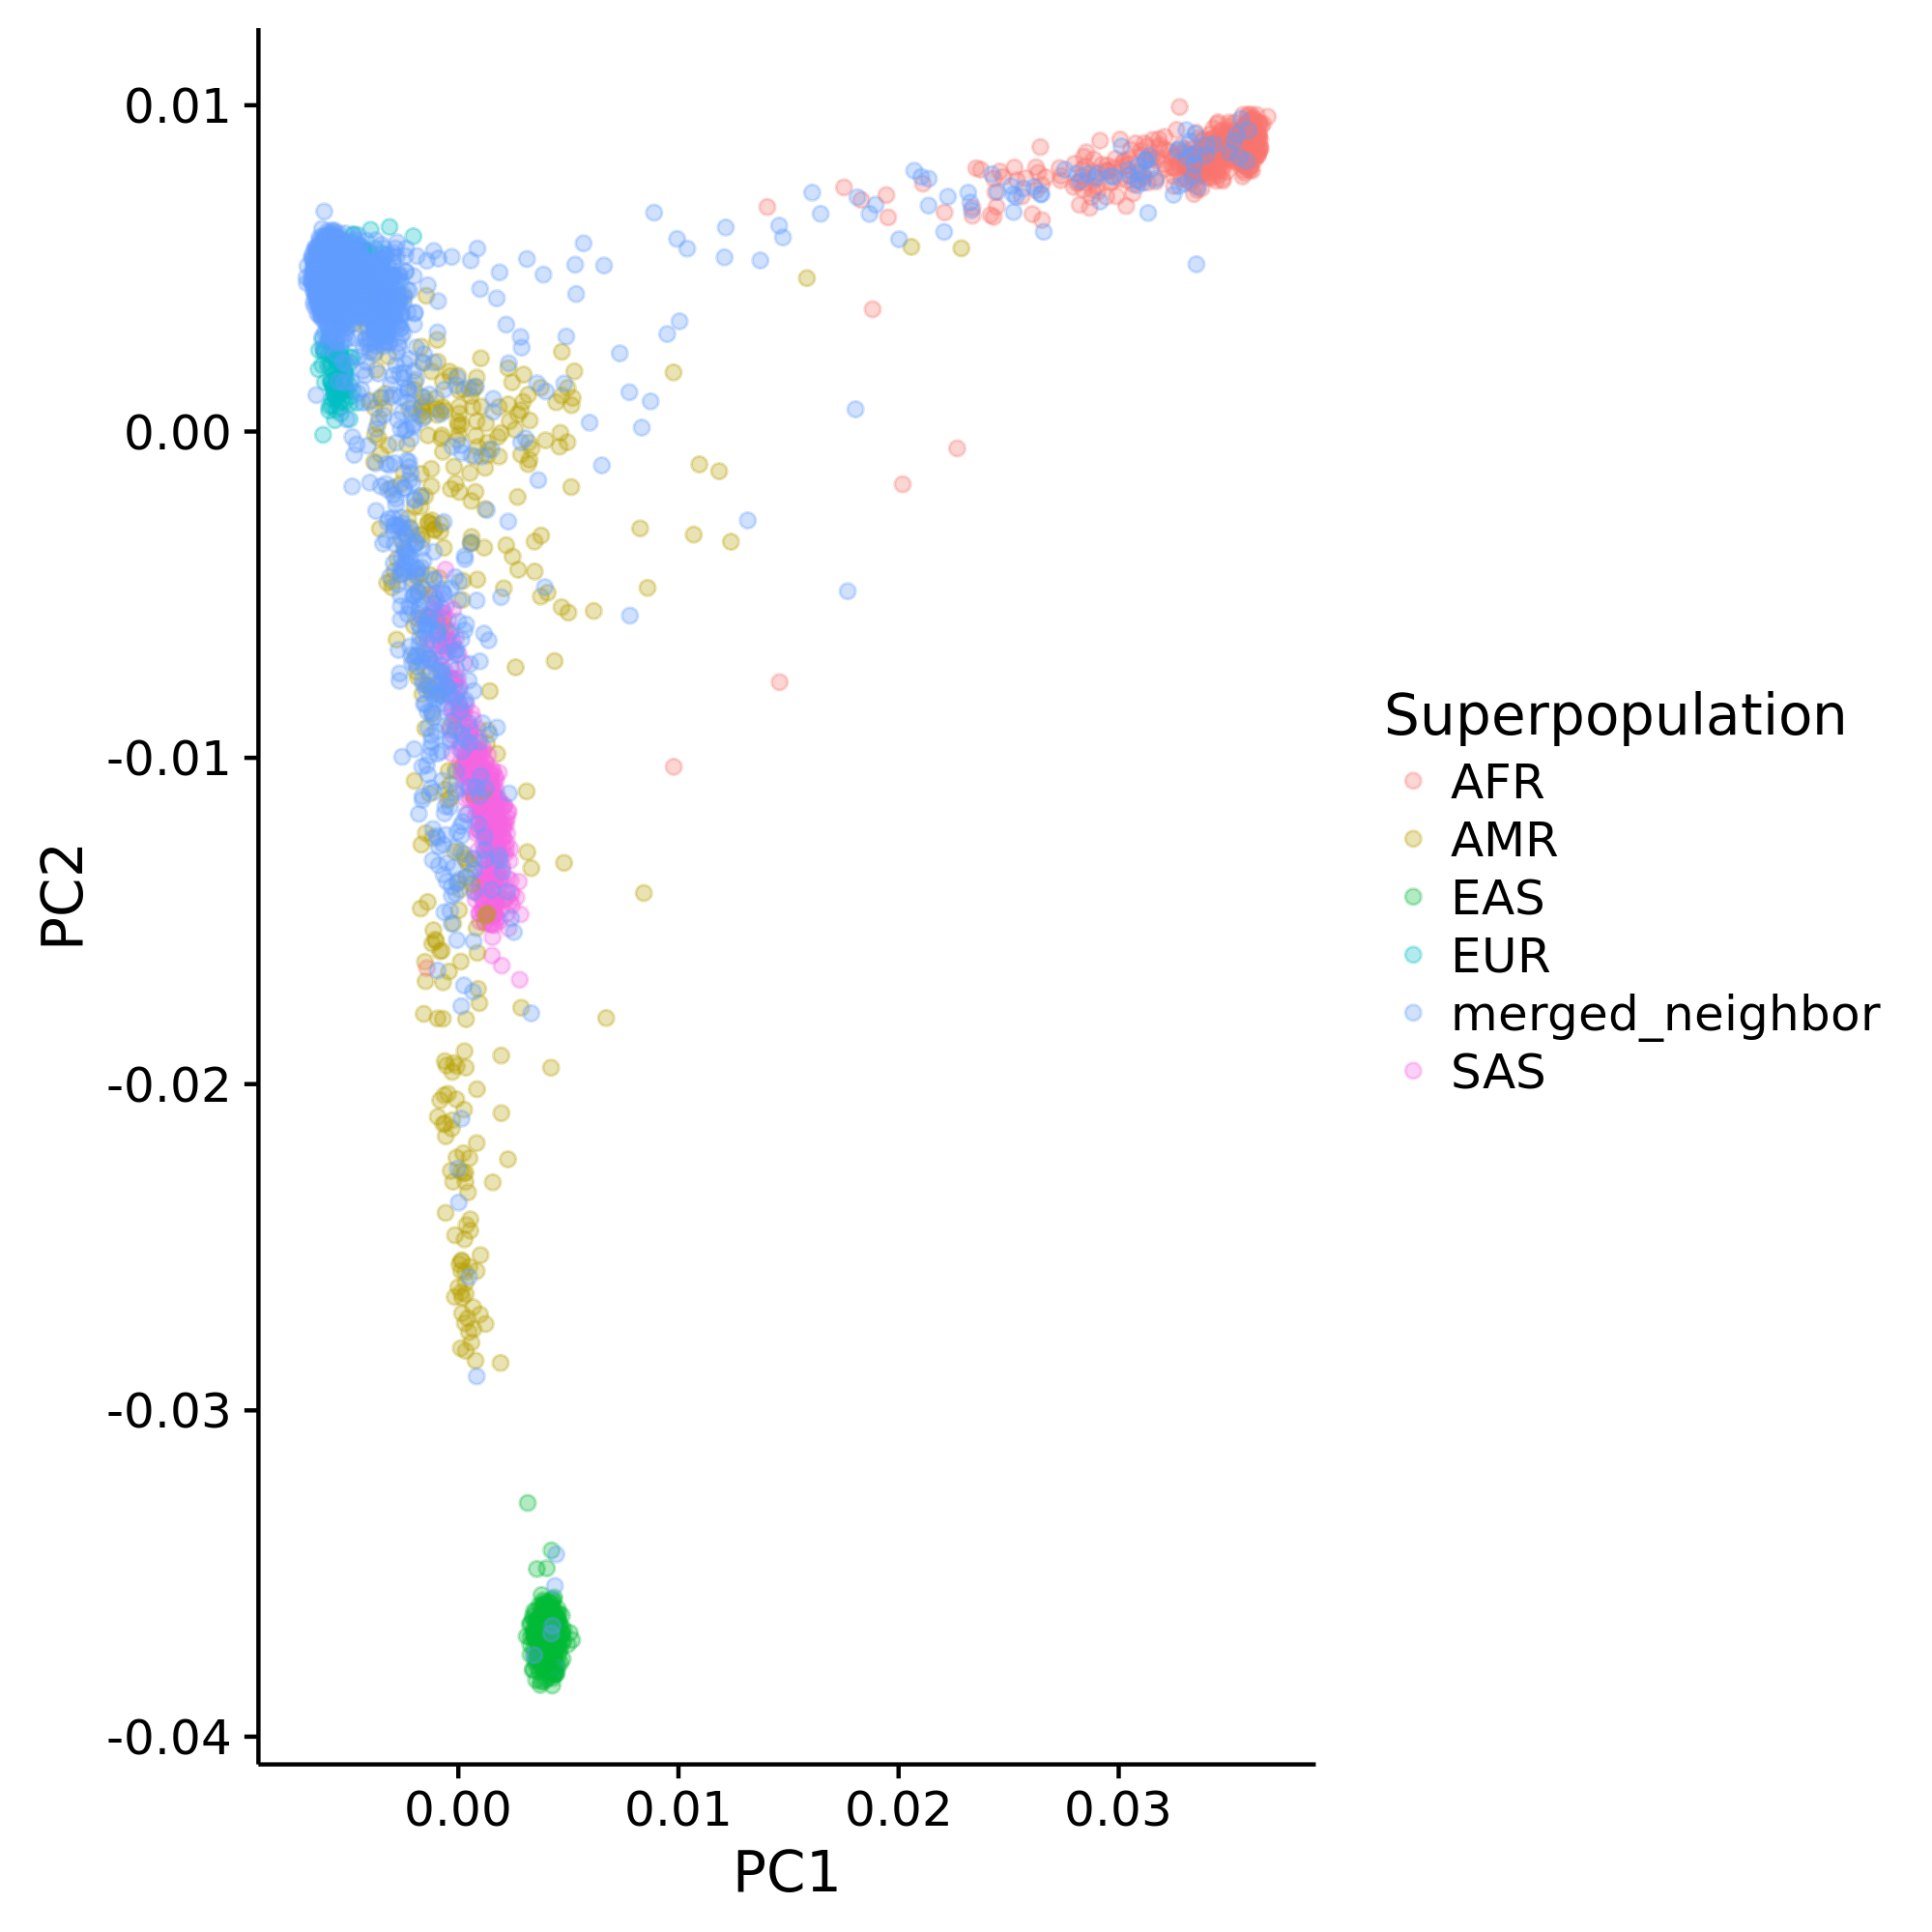

In [78]:
'''Now plot PC1 against PC2.'''
%R pca <- read.table("plink.eigenvec.labeled", sep="\t", header=T)
%R library(ggplot2)
%R library(cowplot, quietly=T)
%R pc1_vs_pc2_plot <- ggplot(pca, aes(x=PC1, y=PC2, colour=Superpopulation)) + geom_point(alpha=0.3)
%R ggsave('pc1_vs_pc2_plot.pdf')
%R ggsave('pc1_vs_pc2_plot.png') #For viewing in the notebook.
Image("pc1_vs_pc2_plot.png")

In [79]:
'''Update running Results() object.'''
results.add_result(Result(12, 'PCA', count_snps_and_samples(input_filestem)).get_result())
#results.get_results() #Feel free to uncomment this to see the running result.

In [80]:
'''Final step: save results table.'''
results.get_results().to_csv('GWAS_QC_results.csv', index=False)
results.get_results()

,step_number,step_name,n_snps,n_samples
0,1.0,Sexcheck,655216.0,5032.0
1,2.0,Marker callrate,555021.0,5032.0
2,3.0,Sample callrate,555021.0,5032.0
3,4.0,MAF,535483.0,5032.0
4,5.0,IBD,535483.0,4949.0
5,6.0,Outlying heterozygosity,535483.0,4949.0
6,7.0,Marker callrate,535479.0,4949.0
7,8.0,Sample callrate,535479.0,4949.0
8,9.0,MAF,535447.0,4949.0
9,10.0,HWE,525671.0,4949.0


In [91]:
'''QC is now complete!  Download this notebook, the high-resolution graphics, and the final Plink filestem.
You can download from the running instance using the following command. You just need to use the key-pair file
for the EC2 instance (substitute its file name for my_key_pair.pem)'''
!rm *~ #Clean up intermediate files.

ip_str = !wget -qO- http://instance-data/latest/meta-data/public-ipv4 #EC2 URL for getting the public IPv4 address.
ip_address = ip_str[0] #Convert to Python string.
sftp_target = 'ec2-user@' + str(ip_address) + ':' #Base SFTP server endpoint.
dataset_sftp_target = sftp_target + study_dir + '/' + input_filestem + '.*' #For the cleaned up Plink study.
pdf_sftp_target = sftp_target + study_dir + '/' + '*.pdf' #For PDF grahics generated during GWAS QC.
csv_sftp_target = sftp_target + study_dir + '/' + 'GWAS_QC_results.csv'
pca_sftp_target = sftp_target + study_dir + '/' + 'plink.eigenvec' #Contains PC1-20, keyed by FID and IID.
notebook_sftp_target = sftp_target + '/clink/CLINK/GWAS_QC.ipynb' #If you renamed the notebook,
# change this to the new notebook name.

print 'sftp -i my_key_pair.pem ' + dataset_sftp_target
print 'sftp -i my_key_pair.pem ' + notebook_sftp_target
print 'sftp -i my_key_pair.pem ' + pdf_sftp_target
print 'sftp -i my_key_pair.pem ' + csv_sftp_target
print 'sftp -i my_key_pair.pem ' + pca_sftp_target

'''Advanced users may use git to clone the notebook and S3 to store the data.
HOWEVER, note that including any credentials (e.g. git profile, AWS credentials)
on an image of the EC2 instance is a SECURITY RISK!
If you add any credentials to the EC2 instance, DO NOT TAKE AN AMI IMAGE
OR AN EBS SNAPSHOT becuase the image will contain your credentials.'''

rm: cannot remove ‘*~’: No such file or directory
sftp -i my_key_pair.pem ec2-user@107.23.183.146:/clink/merged_neighbor/merged_neighbor.*
sftp -i my_key_pair.pem ec2-user@107.23.183.146:/clink/CLINK/GWAS_QC.ipynb
sftp -i my_key_pair.pem ec2-user@107.23.183.146:/clink/merged_neighbor/*.pdf
sftp -i my_key_pair.pem ec2-user@107.23.183.146:/clink/merged_neighbor/GWAS_QC_results.csv
sftp -i my_key_pair.pem ec2-user@107.23.183.146:/clink/merged_neighbor/plink.eigenvec


In [ ]:
'''Now that you have downloaded the notebook, cleaned up dataset, PDF graphics, and CSV report of QC,
you can go ahead and shut down the EC2 instance from the AWS console and also delete the EBS volumes.
EBS volumes persist: they aren't deleted when you shut down the instance, so make sure to delete them.'''